In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read training data
dataset_train = pd.read_csv('./../storage/v4_21milrows.csv', nrows=100000)

In [3]:
# Currently excluding DateTime (string) and support + resistance
# Required format: Open, High, Low, Last, Volume, NumberOfTrades, BidVolume, AskVolume, Speed, Acceleration, Distance, VWAP
exclude = ['DateTime', 'Support', 'Resistance']

In [4]:
dataset_train = dataset_train.drop(columns=exclude)

In [5]:
# Filter out NaN and inf values (MinMaxScaler can't handle)
dataset_train = dataset_train.fillna(0)
dataset_train = dataset_train.replace(np.inf, 9999)
dataset_train = dataset_train.replace(-np.inf, -9999)

In [6]:
# Convert data into numpy array - use float32 to save memory
training_set = dataset_train.values.astype('float32')

In [7]:
# Normalize dataset values
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Define timesteps
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [10]:
# Train model - repeat adding LSTM layers w/ dropout layers to prevent overfitting
model = Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=900))
model.compile(optimizer='adam',loss='mean_squared_error')

# Runs for 100 epochs w/ batches of 32 - learns to make predictions from x_train and minimize MSE in y_train
model.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
1562/1562 [==============================] - 141s 88ms/step - loss: 0.0031
Epoch 2/100
1562/1562 [==============================] - 138s 88ms/step - loss: 5.8337e-04
Epoch 3/100
1562/1562 [==============================] - 138s 88ms/step - loss: 3.8273e-04
Epoch 4/100
1562/1562 [==============================] - 137s 88ms/step - loss: 2.8821e-04
Epoch 5/100
1562/1562 [==============================] - 135s 86ms/step - loss: 2.5552e-04
Epoch 6/100
1562/1562 [==============================] - 135s 86ms/step - loss: 2.2586e-04
Epoch 7/100
1562/1562 [==============================] - 135s 86ms/step - loss: 2.1951e-04
Epoch 8/100
1562/1562 [==============================] - 135s 86ms/step - loss: 2.0684e-04
Epoch 9/100
1562/1562 [==============================] - 135s 86ms/step - loss: 2.0501e-04
Epoch 10/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.9673e-04
Epoch 11/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.9599e-04
E

1562/1562 [==============================] - 135s 86ms/step - loss: 1.3847e-04
Epoch 91/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.3780e-04
Epoch 92/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.3919e-04
Epoch 93/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.3952e-04
Epoch 94/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.3755e-04
Epoch 95/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.3955e-04
Epoch 96/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.3579e-04
Epoch 97/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.4082e-04
Epoch 98/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.3658e-04
Epoch 99/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.3915e-04
Epoch 100/100
1562/1562 [==============================] - 135s 86ms/step - loss: 1.3671e-04


In [11]:
from keras.models import load_model
model.save('v2_model.h5')

In [12]:
# Read testing data
dataset_test = pd.read_csv('./../storage/v4_21milrows.csv', skiprows=range(1, 100000), nrows=100000)

In [13]:
# Currently excluding DateTime (string) and support + resistance
exclude = ['DateTime', 'Support', 'Resistance']

In [14]:
dataset_test = dataset_test.drop(columns=exclude)

In [15]:
# Filter out NaN and inf values (MinMaxScaler can't handle)
dataset_test = dataset_test.fillna(0)
dataset_test = dataset_test.replace(np.inf, 9999)
dataset_test = dataset_test.replace(-np.inf, -9999)

In [16]:
# Store actual stock prices (1000)
real_stock_prices = dataset_test['Last'].values

In [17]:
# Convert data into numpy array - use float32 to save memory
testing_set = dataset_test.values.astype('float32')

In [18]:
# Merge sets
dataset_total = pd.concat((dataset_train, dataset_test), axis=0)

In [19]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [20]:
inputs = inputs.reshape(-1,12)
inputs = sc.transform(inputs)

In [21]:
# Prepare test sequences (60-1060) signifies predicting next 1000 timesteps
X_test = []
for i in range(60, 100060):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
predicted_stock_features = model.predict(X_test)
predicted_stock_features = sc.inverse_transform(predicted_stock_features)

ValueError: operands could not be broadcast together with shapes (100000,900) (12,) (100000,900) 

In [28]:
# Get only last prices (4th feature)
predicted_stock_prices = predicted_stock_features[:, 3]


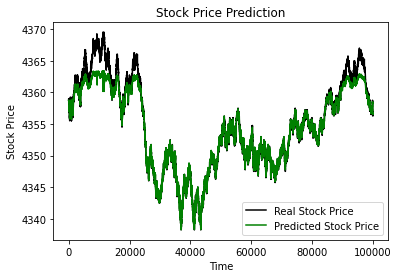

In [29]:
plt.plot(real_stock_prices, color='black', label='Real Stock Price')
plt.plot(predicted_stock_prices, color='green', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()